In [1]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch
from torch_geometric.nn import Node2Vec
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import random
import xgboost as xgb

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = Planetoid(root='/tmp', name='Cora')
data = dataset[0]
G = to_networkx(data, to_undirected=True)

In [3]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
labels = data.y
labels


tensor([3, 4, 4,  ..., 3, 3, 3])

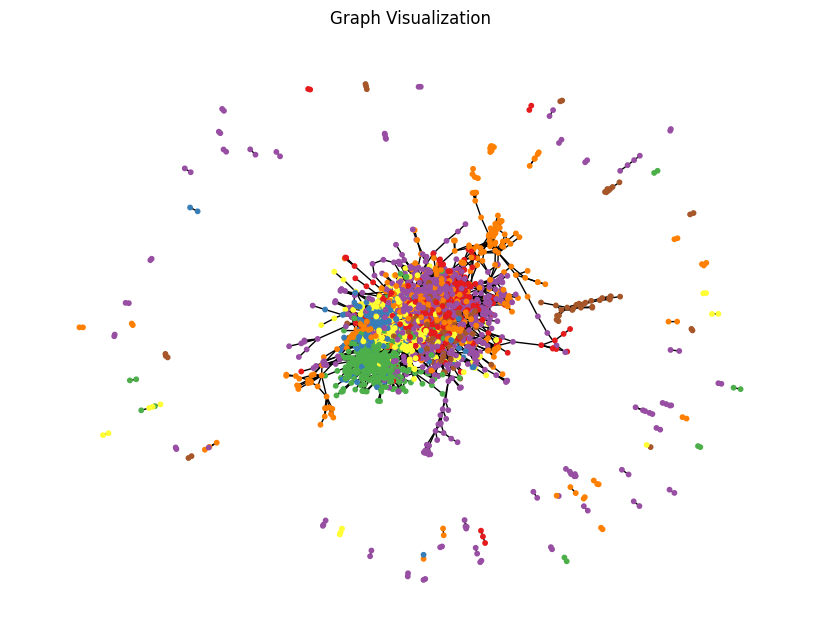

In [5]:
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
color_map = [colors[label] for label in labels]
    
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=False, node_size=10, node_color=color_map)
plt.title("Graph Visualization")
plt.show()

# Creating Embeddings

## Node2Vec

In [6]:

model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walks_per_node=10,
    walk_length=20,
    context_size=10,
    p=1.0,
    q=1.0,
    num_negative_samples=1,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
loader = model.loader(batch_size=128, shuffle=False, num_workers=4)

In [8]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [9]:
for i in range(100):
    train()
embeddings_node2vec = model().detach().numpy()

In [10]:
embeddings_node2vec

array([[ 0.31173906, -0.04959387, -0.0193128 , ...,  0.11776933,
        -0.03731802, -0.12204098],
       [ 0.4576739 , -0.17036825,  0.07782593, ..., -0.16473499,
         0.54808146, -0.02413876],
       [ 0.5660015 , -0.09824537,  0.20704442, ..., -0.27871114,
         0.4970042 , -0.20398605],
       ...,
       [ 0.07171978, -0.23001955,  0.11761186, ..., -0.08275972,
         0.07509346, -0.07183763],
       [-0.2809757 ,  0.671722  ,  0.3596349 , ...,  0.01923881,
         0.02092247, -0.31661648],
       [-0.19329216,  0.47346053,  0.38256693, ...,  0.19809887,
        -0.01466027, -0.36196208]], dtype=float32)

## DeepWalk

[source](https://www.kaggle.com/code/shakshisharma/graph-embeddings-deepwalk-and-node2vec)

In [11]:
def get_random_walk(node, walk_length):
    random_walk_length = [node]
    for i in range(walk_length-1):
        neighbors = list(G.neighbors(node))
        neighbors = list(set(neighbors) - set(random_walk_length))    
        if len(neighbors) == 0:
            break
        random_neighbor = random.choice(neighbors)
        random_walk_length.append(random_neighbor)
        node = random_neighbor
        
    return random_walk_length

all_nodes = list(G.nodes())
number_of_random_walks = 5
random_walks = []

for node in tqdm(all_nodes):
    for i in range(number_of_random_walks):
        random_walks.append(get_random_walk(node, 10))
        
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10,
                 alpha=0.03, min_alpha=0.0007,
    )
model.build_vocab(random_walks, progress_per=2)
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)


100%|██████████| 2708/2708 [00:00<00:00, 5918.22it/s]


(2109133, 2146220)

In [12]:
embeddings_deepwalk = np.array([model.wv[node] for node in range(len(data.x))])

In [13]:
embeddings_deepwalk

array([[-0.6946879 ,  0.4748623 ,  0.07556441, ...,  0.04621211,
         0.18880172, -0.44666716],
       [-0.84066516,  0.5103153 ,  0.2695326 , ..., -0.31005597,
         0.421747  ,  0.19723676],
       [-1.0936682 ,  0.61366946,  0.21016678, ..., -0.18342511,
         0.5304327 ,  0.04324118],
       ...,
       [-0.06566019,  0.05478809,  0.07404137, ..., -0.09685707,
        -0.08946288,  0.00386702],
       [-0.43042716,  0.39812434,  0.40270612, ...,  0.02842423,
         0.3705806 ,  0.0327999 ],
       [-0.5009732 ,  0.45934373,  0.62711996, ..., -0.00917188,
         0.37681368,  0.0204059 ]], dtype=float32)

# Creating Reduced Embeddings

In [14]:
def reduce_embeddings(embeddings, method="PCA"):
    match method:
        case "TSNE" :
            tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=50)
            return tsne.fit_transform(embeddings)
        case "PCA" | _:
            pca = PCA(n_components=2)
            return pca.fit_transform(embeddings)

In [15]:
def plot_embeddings(embeddings, labels, title=""):
    x, y = zip(*embeddings)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette(colors))
    plt.title(title)
    plt.show()

## Node2Vec

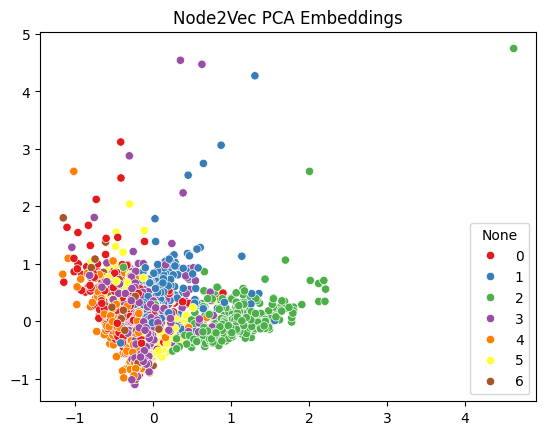

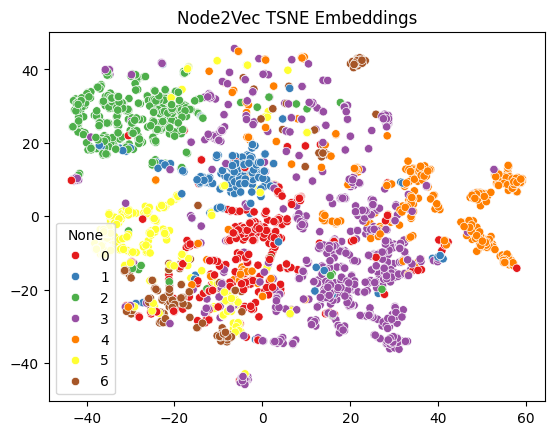

In [16]:
pca_embeddings = reduce_embeddings(embeddings_node2vec, method="PCA")
tsne_embeddings = reduce_embeddings(embeddings_node2vec, method="TSNE")
plot_embeddings(pca_embeddings, labels, "Node2Vec PCA Embeddings")
plot_embeddings(tsne_embeddings, labels, "Node2Vec TSNE Embeddings")


## DeepWalk

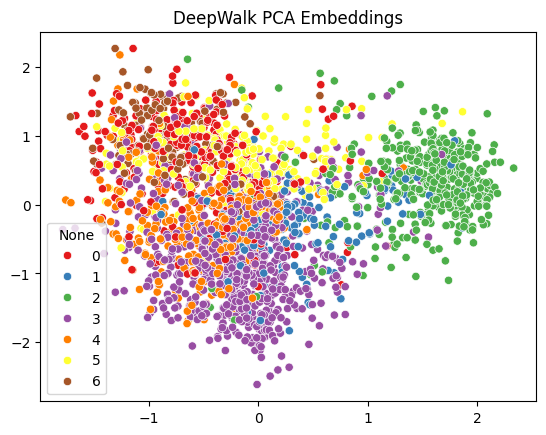

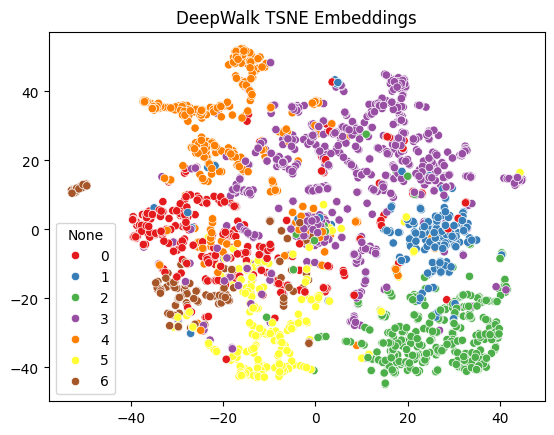

In [17]:
pca_embeddings = reduce_embeddings(embeddings_deepwalk, method="PCA")
tsne_embeddings = reduce_embeddings(embeddings_deepwalk, method="TSNE")
plot_embeddings(pca_embeddings, labels, "DeepWalk PCA Embeddings")
plot_embeddings(tsne_embeddings, labels, "DeepWalk TSNE Embeddings")


# Classification

In [18]:
def plot_confusion_matrix(y_pred, y_test, title):
    cm = confusion_matrix(y_pred, y_test)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: ' + title)
    plt.show()

In [19]:
def get_knn_prediction(X_train, X_test, y_train):
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X_train, y_train)
    return neigh.predict(X_test)

In [20]:
def get_xgboost_prediction(X_train, X_test, y_train):
    clf = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

In [21]:
def evaluate(y_pred, y_test):
    df = pd.DataFrame({"prediction": y_pred, "actual": y_test})
    display(df.head(10))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("accuracy:", accuracy_score(y_pred, y_test))
    print("f1_score:", f1_score(y_pred, y_test, average='macro'))

In [22]:
def compare_classifiers(embeddings):
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42)
    
    #KNN on whole embeddings
    y_pred = get_knn_prediction(X_train, X_test, y_train)
    plot_confusion_matrix(y_pred, y_test, "KNN on whole embeddings")
    evaluate(y_pred, y_test)
    print('-' * 50)
    
    #XGBoost on whole embeddings
    y_pred = get_xgboost_prediction(X_train, X_test, y_train)
    plot_confusion_matrix(y_pred, y_test, "XGBoost on whole embeddings")
    evaluate(y_pred, y_test)
    print('-' * 50)
    
    
    reduced_embeddings = reduce_embeddings(embeddings, method="PCA")
    X_train, X_test, y_train, y_test = train_test_split(
        reduced_embeddings, labels, test_size=0.2, random_state=42)
    
    #KNN on reduced embeddings
    y_pred = get_knn_prediction(X_train, X_test, y_train)
    plot_confusion_matrix(y_pred, y_test, "KNN on reduced embeddings")
    evaluate(y_pred, y_test)
    print('-' * 50)
    
    
    #XGBoost on reduced embeddings
    y_pred = get_xgboost_prediction(X_train, X_test, y_train)
    plot_confusion_matrix(y_pred, y_test, "XGBoost on reduced embeddings")
    evaluate(y_pred, y_test)
    print('-' * 50)
    
    

## Node2Vec embeddings

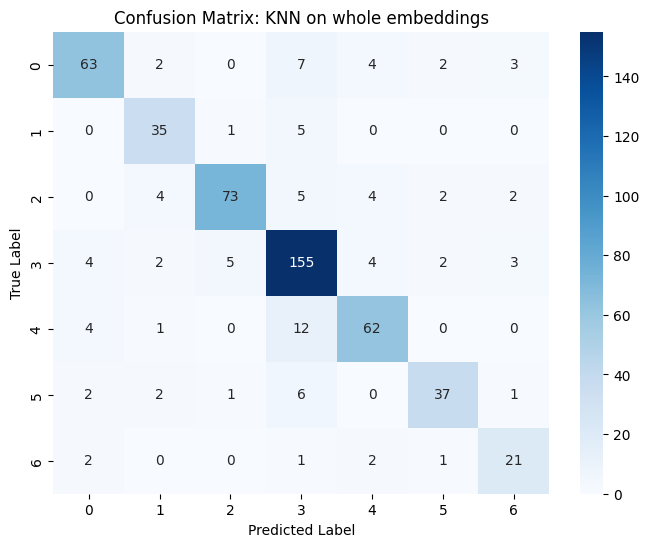

,prediction,actual
0,4,3
1,2,2
2,2,2
3,2,2
4,4,0
5,5,5
6,3,3
7,1,1
8,3,3
9,3,1



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        75
           1       0.85      0.76      0.80        46
           2       0.81      0.91      0.86        80
           3       0.89      0.81      0.85       191
           4       0.78      0.82      0.80        76
           5       0.76      0.84      0.80        44
           6       0.78      0.70      0.74        30

    accuracy                           0.82       542
   macro avg       0.81      0.81      0.81       542
weighted avg       0.83      0.82      0.82       542

accuracy: 0.8228782287822878
f1_score: 0.8072355862524233
--------------------------------------------------


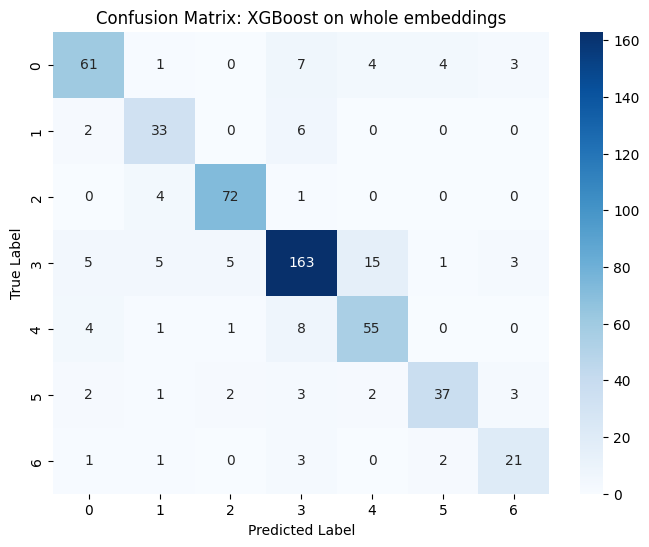

,prediction,actual
0,3,3
1,2,2
2,2,2
3,2,2
4,0,0
5,5,5
6,3,3
7,1,1
8,3,3
9,1,1



Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        75
           1       0.80      0.72      0.76        46
           2       0.94      0.90      0.92        80
           3       0.83      0.85      0.84       191
           4       0.80      0.72      0.76        76
           5       0.74      0.84      0.79        44
           6       0.75      0.70      0.72        30

    accuracy                           0.82       542
   macro avg       0.80      0.79      0.80       542
weighted avg       0.82      0.82      0.82       542

accuracy: 0.8154981549815498
f1_score: 0.7961591092696968
--------------------------------------------------


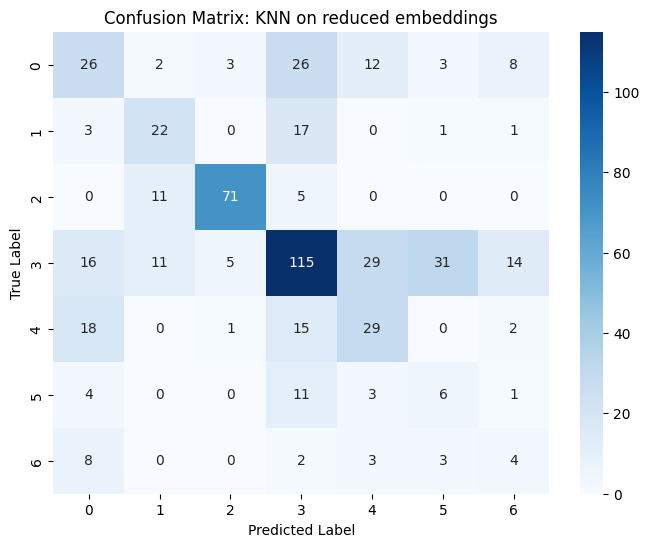

,prediction,actual
0,4,3
1,2,2
2,0,2
3,2,2
4,3,0
5,3,5
6,3,3
7,1,1
8,3,3
9,1,1



Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.35      0.34        75
           1       0.50      0.48      0.49        46
           2       0.82      0.89      0.85        80
           3       0.52      0.60      0.56       191
           4       0.45      0.38      0.41        76
           5       0.24      0.14      0.17        44
           6       0.20      0.13      0.16        30

    accuracy                           0.50       542
   macro avg       0.44      0.42      0.43       542
weighted avg       0.48      0.50      0.49       542

accuracy: 0.503690036900369
f1_score: 0.42545502134963703
--------------------------------------------------


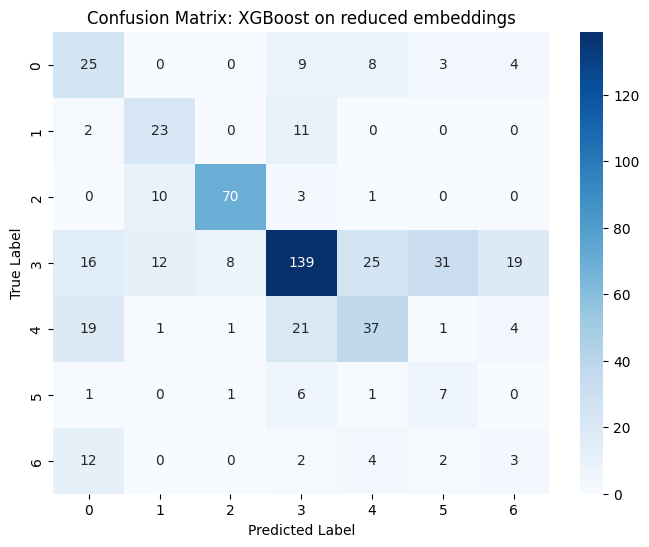

,prediction,actual
0,4,3
1,2,2
2,2,2
3,2,2
4,3,0
5,3,5
6,3,3
7,1,1
8,3,3
9,1,1



Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.33      0.40        75
           1       0.64      0.50      0.56        46
           2       0.83      0.88      0.85        80
           3       0.56      0.73      0.63       191
           4       0.44      0.49      0.46        76
           5       0.44      0.16      0.23        44
           6       0.13      0.10      0.11        30

    accuracy                           0.56       542
   macro avg       0.51      0.45      0.47       542
weighted avg       0.55      0.56      0.54       542

accuracy: 0.5608856088560885
f1_score: 0.4653266172606522
--------------------------------------------------


In [23]:
compare_classifiers(embeddings_node2vec)

## DeepWalk embeddings

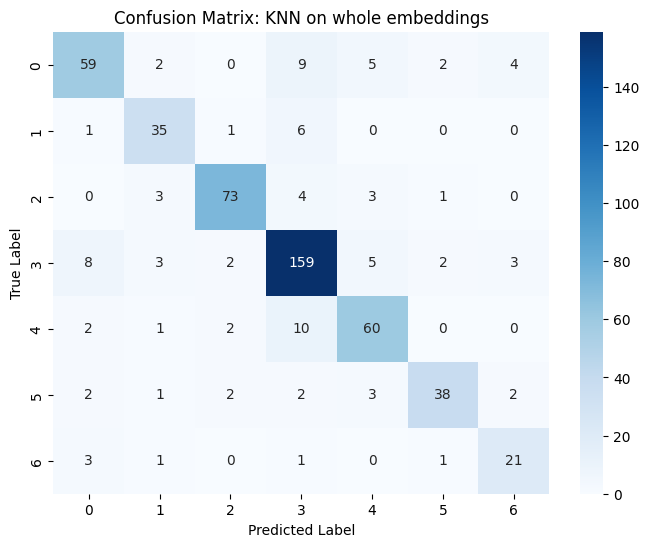

,prediction,actual
0,4,3
1,2,2
2,2,2
3,2,2
4,1,0
5,5,5
6,3,3
7,1,1
8,3,3
9,1,1



Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        75
           1       0.81      0.76      0.79        46
           2       0.87      0.91      0.89        80
           3       0.87      0.83      0.85       191
           4       0.80      0.79      0.79        76
           5       0.76      0.86      0.81        44
           6       0.78      0.70      0.74        30

    accuracy                           0.82       542
   macro avg       0.80      0.81      0.80       542
weighted avg       0.82      0.82      0.82       542

accuracy: 0.8210332103321033
f1_score: 0.8036818085697061
--------------------------------------------------


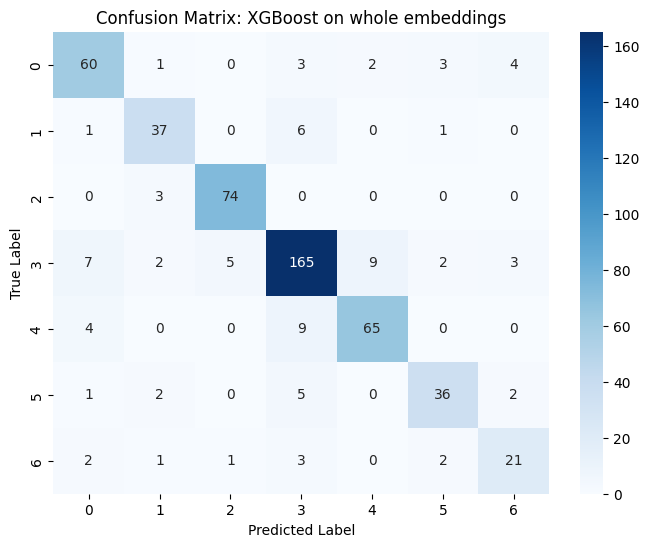

,prediction,actual
0,3,3
1,2,2
2,2,2
3,2,2
4,1,0
5,5,5
6,3,3
7,1,1
8,3,3
9,1,1



Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        75
           1       0.82      0.80      0.81        46
           2       0.96      0.93      0.94        80
           3       0.85      0.86      0.86       191
           4       0.83      0.86      0.84        76
           5       0.78      0.82      0.80        44
           6       0.70      0.70      0.70        30

    accuracy                           0.85       542
   macro avg       0.83      0.82      0.82       542
weighted avg       0.85      0.85      0.85       542

accuracy: 0.8450184501845018
f1_score: 0.8243148039127338
--------------------------------------------------


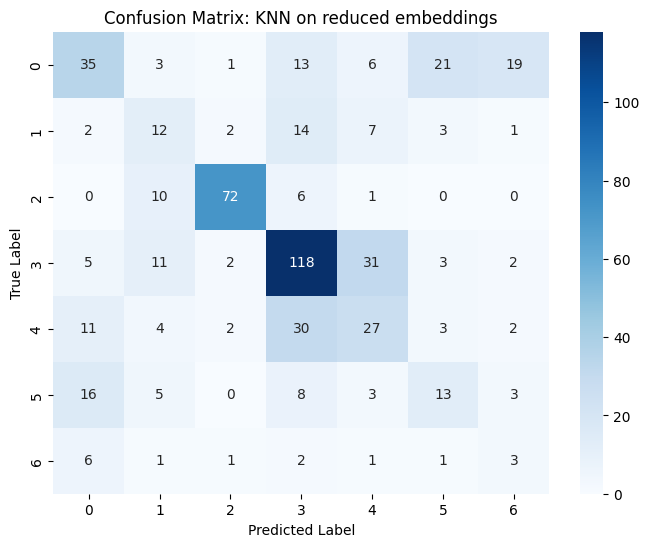

,prediction,actual
0,3,3
1,3,2
2,2,2
3,2,2
4,4,0
5,0,5
6,1,3
7,0,1
8,0,3
9,3,1



Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.47      0.40        75
           1       0.29      0.26      0.28        46
           2       0.81      0.90      0.85        80
           3       0.69      0.62      0.65       191
           4       0.34      0.36      0.35        76
           5       0.27      0.30      0.28        44
           6       0.20      0.10      0.13        30

    accuracy                           0.52       542
   macro avg       0.42      0.43      0.42       542
weighted avg       0.52      0.52      0.51       542

accuracy: 0.5166051660516605
f1_score: 0.4210034598779796
--------------------------------------------------


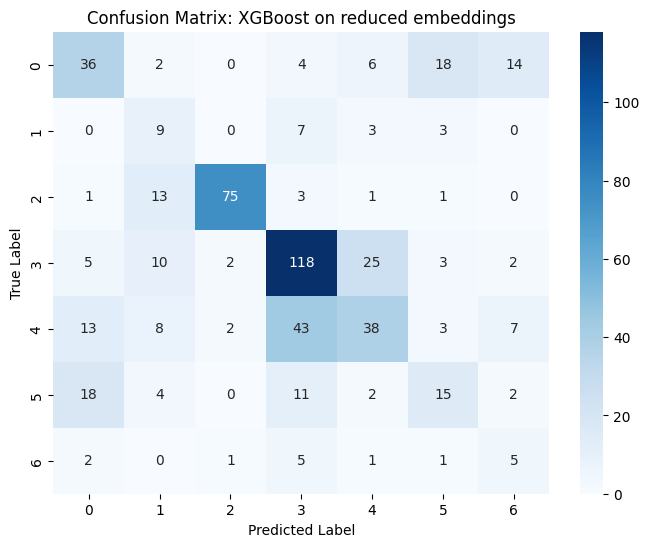

,prediction,actual
0,6,3
1,2,2
2,2,2
3,2,2
4,4,0
5,0,5
6,1,3
7,4,1
8,1,3
9,3,1



Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.48      0.46        75
           1       0.41      0.20      0.26        46
           2       0.80      0.94      0.86        80
           3       0.72      0.62      0.66       191
           4       0.33      0.50      0.40        76
           5       0.29      0.34      0.31        44
           6       0.33      0.17      0.22        30

    accuracy                           0.55       542
   macro avg       0.48      0.46      0.46       542
weighted avg       0.56      0.55      0.54       542

accuracy: 0.5461254612546126
f1_score: 0.45556207820560995
--------------------------------------------------


In [24]:
compare_classifiers(embeddings_deepwalk)

# Clustering

In [25]:
def get_kmeans_results(embeddings):
    kmeans = KMeans(n_clusters=7, random_state=42, n_init="auto")
    embeddings_scaled = StandardScaler().fit_transform(embeddings)
    kmeans.fit(embeddings_scaled)
    return kmeans.predict(embeddings_scaled)

In [26]:
def get_agglomerative_clustering_results(embeddings):
    clustering = AgglomerativeClustering(n_clusters=7)
    embeddings_scaled = StandardScaler().fit_transform(embeddings)
    clustering.fit(embeddings_scaled)
    return clustering.labels_

## Node2Vec embeddings

### KMeans

adjusted_rand_score: 0.2751583557550129


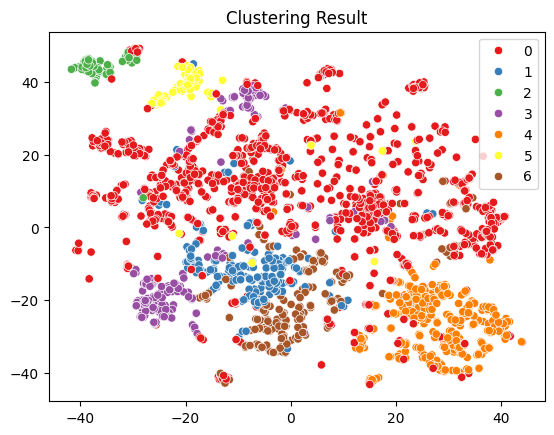

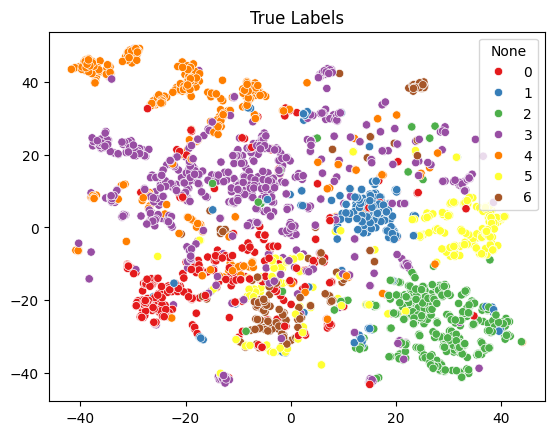

In [27]:
clustering_results = get_kmeans_results(embeddings_node2vec)
print(f"adjusted_rand_score: {adjusted_rand_score(clustering_results, labels)}")

tsne_embeddings = reduce_embeddings(embeddings_node2vec, method="TSNE")
plot_embeddings(tsne_embeddings, clustering_results, "Clustering Result")
plot_embeddings(tsne_embeddings, labels, "True Labels")

### Hierarchical Clustering

adjusted_rand_score: 0.34298667468509064


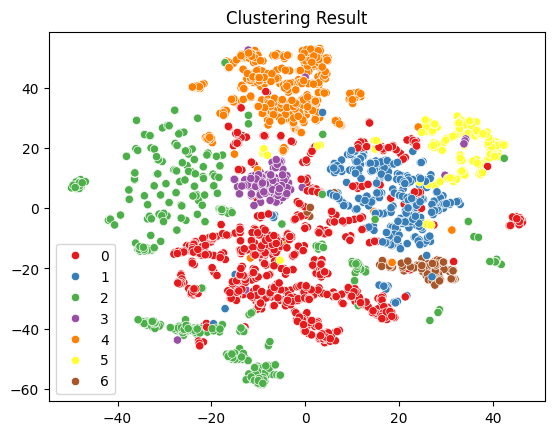

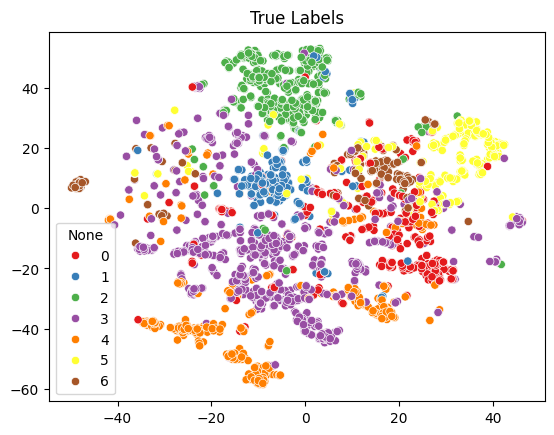

In [28]:
clustering_results = get_agglomerative_clustering_results(embeddings_node2vec)
print(f"adjusted_rand_score: {adjusted_rand_score(clustering_results, labels)}")

tsne_embeddings = reduce_embeddings(embeddings_node2vec, method="TSNE")
plot_embeddings(tsne_embeddings, clustering_results, "Clustering Result")
plot_embeddings(tsne_embeddings, labels, "True Labels")

## DeepWalk embeddings

### KMeans

adjusted_rand_score: 0.2671379351505889


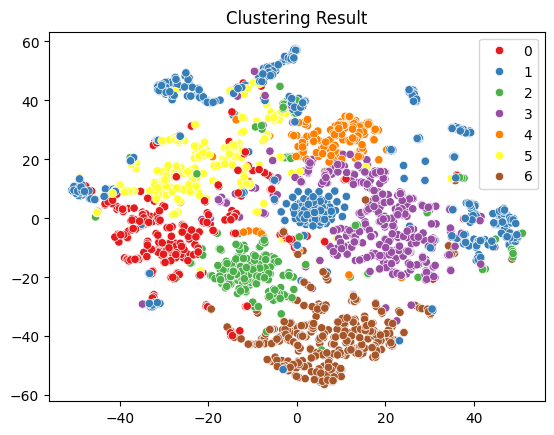

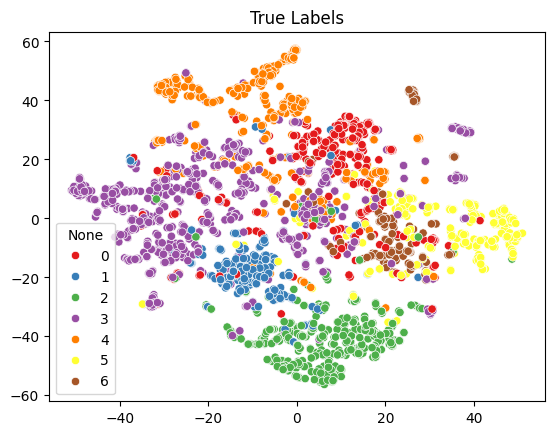

In [29]:
clustering_results = get_kmeans_results(embeddings_deepwalk)
print(f"adjusted_rand_score: {adjusted_rand_score(clustering_results, labels)}")

tsne_embeddings = reduce_embeddings(embeddings_deepwalk, method="TSNE")
plot_embeddings(tsne_embeddings, clustering_results, "Clustering Result")
plot_embeddings(tsne_embeddings, labels, "True Labels")

### Hierarchical Clustering

adjusted_rand_score: 0.311082085474073


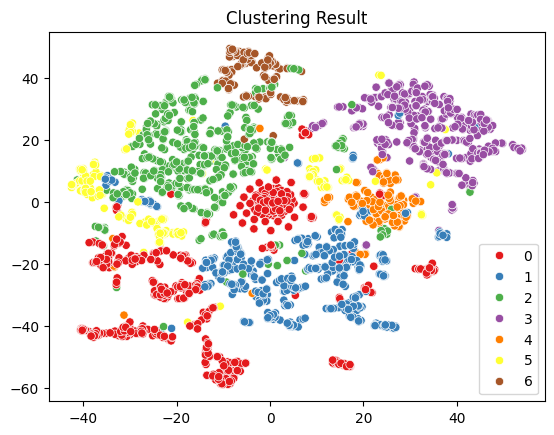

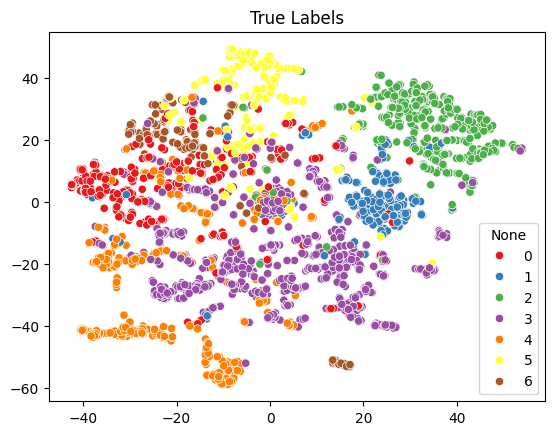

In [30]:
clustering_results = get_agglomerative_clustering_results(embeddings_deepwalk)
print(f"adjusted_rand_score: {adjusted_rand_score(clustering_results, labels)}")

tsne_embeddings = reduce_embeddings(embeddings_deepwalk, method="TSNE")
plot_embeddings(tsne_embeddings, clustering_results, "Clustering Result")
plot_embeddings(tsne_embeddings, labels, "True Labels")